In [65]:
import pandas as pd
import pandas_ta as ta
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import numpy as np
import requests
import matplotlib.pyplot as plt
from math import floor
from termcolor import colored as cl
from binance.client import Client
import datetime as dt
import json
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import *
import graphviz
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from itertools import product
import math
from numpy import nan
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
import graphviz
import shap
from lime.lime_tabular import LimeTabularExplainer
from bfs import bfs
from flagrules import flagrules
from datacollection import datacollection
from LSTMpred import *
from obv import *
from rsi import rsi_buy_sell
from arimatesting import *
from macd import get_macd
from stochastic import get_stoch_osc
from calc import calc
from implement_stoch_macd_strategy_optimization import *
from ema import *
from bruteforce import *
from decisiontree import decisiontree

plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (20,10)

def main():

    data = datacollection()

    # MACD CALCULATION
    # data['macd'] = get_macd(data['close'], 26, 12, 9)[0]
    # data['macd_signal'] = get_macd(data['close'], 26, 12, 9)[1]
    # data['macd_hist'] = get_macd(data['close'], 26, 12, 9)[2]
    # data = data.dropna()

    data = calc(data)

    print("data before bruteforce", data.columns)
    bruteforce(data)

main()

data before bruteforce Index(['datetime', 'open', 'high', 'low', 'close', 'volume', 'close_time',
       'qav', 'num_trades', 'taker_base_vol', 'taker_quote_vol', 'ignore',
       '%k', '%d', 'macd', 'macd_signal', 'macd_hist', 'RSI_14', 'RSI_14_A_50',
       'RSI_14_B_55', 'EMA10', 'EMA30', 'ATR', 'ClgtEMA10', 'EMA10gtEMA30',
       'MACDSIGgtMACD', 'Return', 'OBV', 'OBV_EMA'],
      dtype='object')
the optimized MACD strategy is strategy 124 Below is the strategy trading details  ([nan, 0.939, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.914, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, na

the prediction by classifier is [ 0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1  0 -1  0 -1 -1  0
  0  1  0  0  0  1  0  0  1  1 -1  0  0  0  0  0  0  1  1  0  0  0  0  1
 -1  0  0  0  0  0  1  0  0  0 -1  0 -1  0  0  0  0  0 -1  0  1  0 -1  0
 -1  0]
the true future signal should be [0, -1, 0, -1, 0, -1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, -1, 0, -1, 0, 0, 0, 0, 0, -1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, -1, 0, 1, -1]
              precision    recall  f1-score   support

          -1       0.27      0.33      0.30         9
           0       0.81      0.78      0.80        55
           1       0.30      0.30      0.30        10

    accuracy                           0.66        74
   macro avg       0.46      0.47      0.47        74
weighted avg       0.68      0.66      0.67        74

accuracy score is 66.21621621621621


1/1 [==============================] - 0s 327ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<AxesSubplot: title={'center': 'BTC'}, xlabel='datetime'>

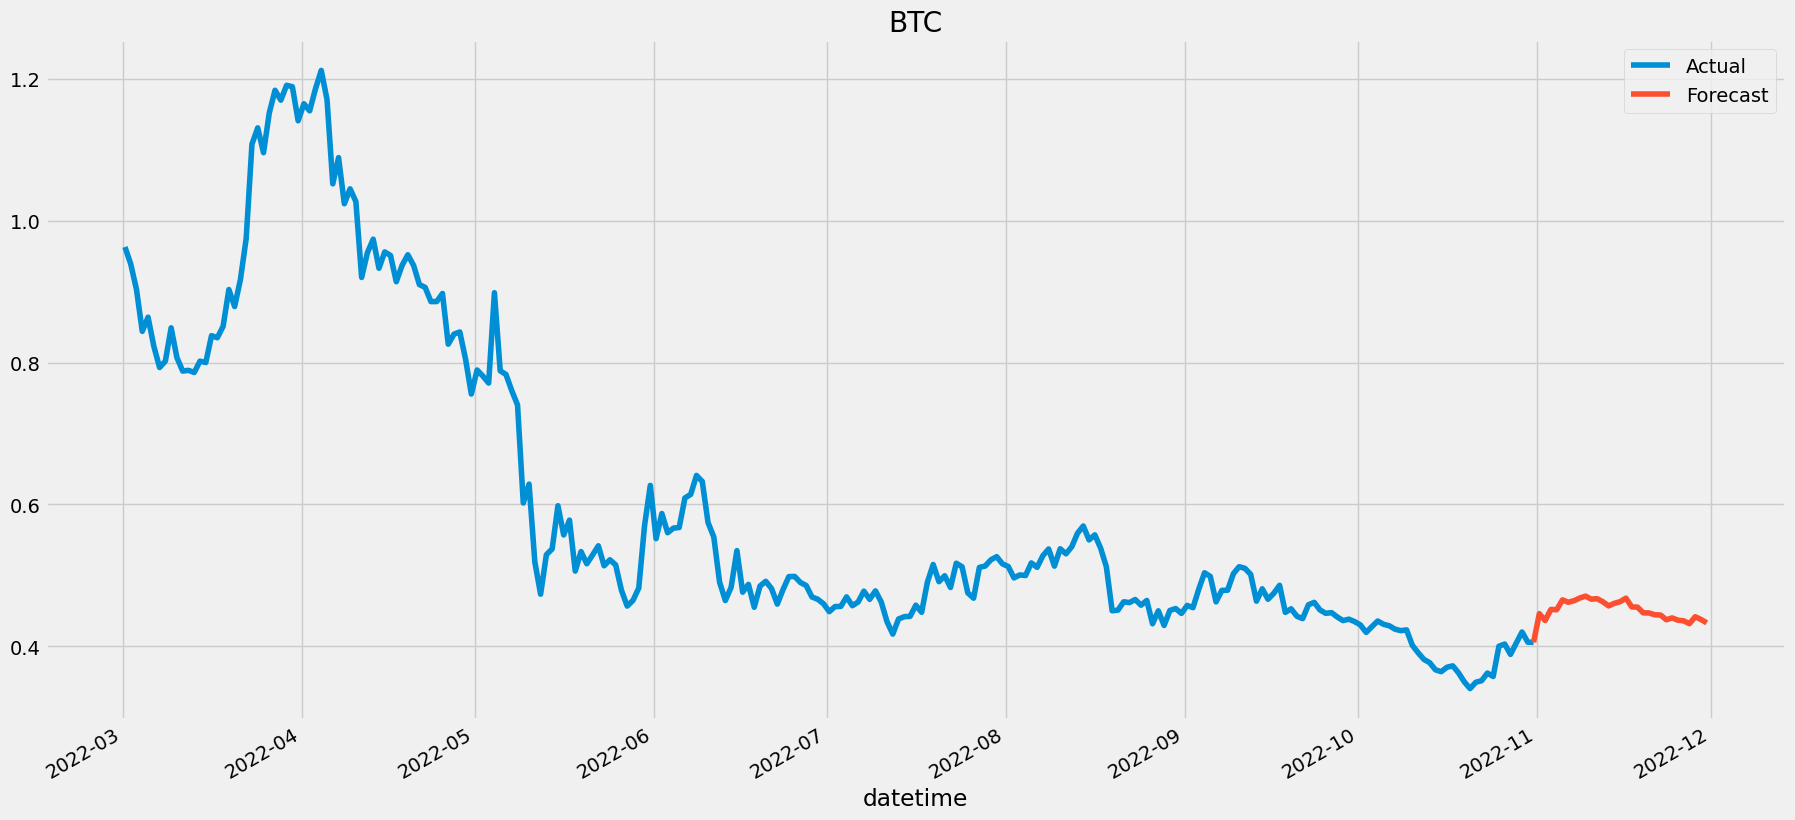

In [8]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
import datetime as dt
import json
import requests
from datacollection import *
pd.options.mode.chained_assignment = None
tf.random.set_seed(0)

# download the data

url = 'https://api.binance.com/api/v3/klines'
start = str(int(dt.datetime(2021,10,1).timestamp()*1000))
end = str(int(dt.datetime(2022,3,1).timestamp()*1000))
    
par = {'symbol': "BTCUSDT",'interval':'1d', 'startTime':start, 'endTime':end}
df = pd.DataFrame(json.loads(requests.get(url, params= par).text))

df.columns = ['datetime', 'open', 'high', 'low', 'close', 'volume','close_time', 'qav', 'num_trades','taker_base_vol', 'taker_quote_vol', 'ignore']
df.index = [x for x in df.datetime]
df=df.astype(float)
df.index = [dt.datetime.fromtimestamp(x/1000.0) for x in df.datetime]

df  = datacollection()


y = df['close'].fillna(method='ffill')
y = y.values.reshape(-1, 1)

# scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaler = scaler.fit(y)
y = scaler.transform(y)



# generate the input and output sequences
n_lookback = 60  # length of input sequences (lookback period)
n_forecast = 30  # length of output sequences (forecast period)

X = []
Y = []

for i in range(n_lookback, len(y) - n_forecast + 1):
    X.append(y[i - n_lookback: i])
    Y.append(y[i: i + n_forecast])

X = np.array(X)
Y = np.array(Y)

# fit the model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(n_lookback, 1)))
model.add(LSTM(units=50))
model.add(Dense(n_forecast))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X, Y, epochs=100, batch_size=32, verbose=0)

# generate the forecasts
X_ = y[- n_lookback:]  # last available input sequence
X_ = X_.reshape(1, n_lookback, 1)

Y_ = model.predict(X_).reshape(-1, 1)
Y_ = scaler.inverse_transform(Y_)

# organize the results in a data frame
df_past = df[['close']].reset_index()
df_past.rename(columns={'index': 'datetime', 'close': 'Actual'}, inplace=True)
df_past['datetime'] = pd.to_datetime(df_past['datetime'])
df_past['Forecast'] = np.nan
df_past['Forecast'].iloc[-1] = df_past['Actual'].iloc[-1]

df_future = pd.DataFrame(columns=['datetime', 'Actual', 'Forecast'])
df_future['datetime'] = pd.date_range(start=df_past['datetime'].iloc[-1] + pd.Timedelta(days=1), periods=n_forecast)
df_future['Forecast'] = Y_.flatten()
df_future['Actual'] = np.nan

results = df_past.append(df_future).set_index('datetime')

# plot the results
results.plot(title='BTC')

overflow encountered in double_scalars


Solution: [-6.15874629e+000 -1.45414488e+154]
Fitness: -inf


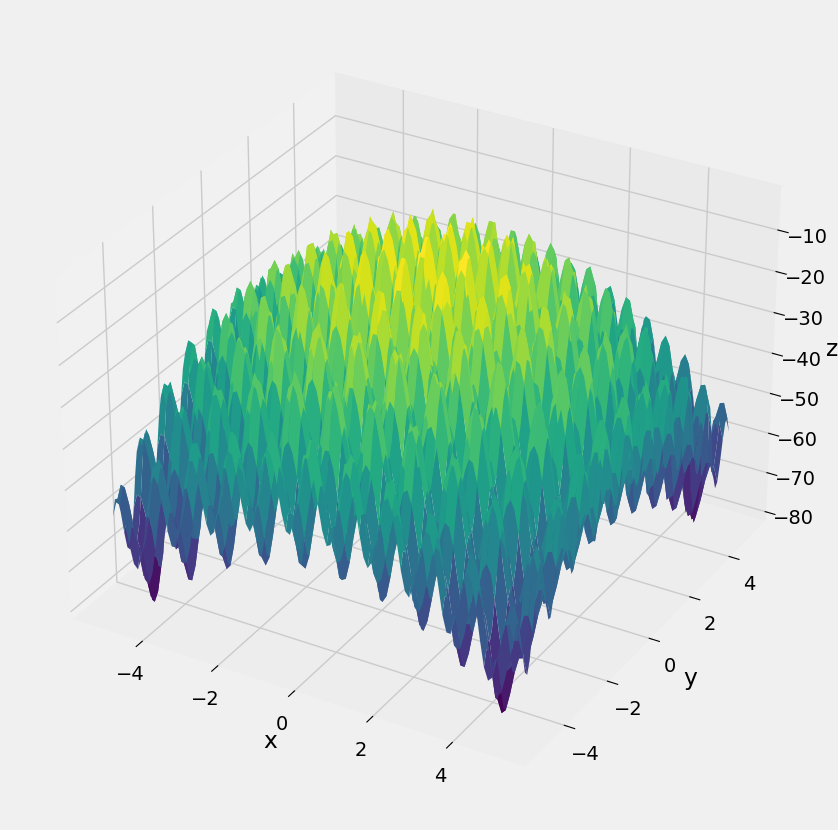

In [64]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Define the Rastrigin function
def rastrigin(x):
    n = len(x)
    return -(10*n + sum([xi**2 - 10*np.cos(2*np.pi*xi) for xi in x]))

# Define the PSO algorithm
def pso(cost_func, dim=2, num_particles=30, max_iter=10000, w=0.5, c1=1, c2=2):
    # Initialize particles and velocities
    particles = np.random.uniform(-5.12, 5.12, (num_particles, dim))
    velocities = np.zeros((num_particles, dim))

    # Initialize the best positions and fitness values
    best_positions = np.copy(particles)
    best_fitness = np.array([cost_func(p) for p in particles])
    swarm_best_position = best_positions[np.argmin(best_fitness)]
    swarm_best_fitness = np.min(best_fitness)

    # Iterate through the specified number of iterations, updating the velocity and position of each particle at each iteration
    for i in range(max_iter):
        # Update velocities
        r1 = np.random.uniform(0, 1, (num_particles, dim))
        r2 = np.random.uniform(0, 1, (num_particles, dim))
        velocities = w * velocities + c1 * r1 * (best_positions - particles) + c2 * r2 * (swarm_best_position - particles)

        # Update positions
        particles += velocities

        # Evaluate fitness of each particle
        fitness_values = np.array([cost_func(p) for p in particles])

        # Update best positions and fitness values
        improved_indices = np.where(fitness_values < best_fitness)
        best_positions[improved_indices] = particles[improved_indices]
        best_fitness[improved_indices] = fitness_values[improved_indices]
        if np.min(fitness_values) < swarm_best_fitness:
            swarm_best_position = particles[np.argmin(fitness_values)]
            swarm_best_fitness = np.min(fitness_values)

    # Return the best solution found by the PSO algorithm
    return swarm_best_position, swarm_best_fitness

# Define the dimensions of the problem
dim = 2

# Run the PSO algorithm on the Rastrigin function
solution, fitness = pso(rastrigin, dim=dim)

# Print the solution and fitness value
print('Solution:', solution)
print('Fitness:', fitness)

# Create a meshgrid for visualization
x = np.linspace(-5.12, 5.12, 100)
y = np.linspace(-5.12, 5.12, 100)
X, Y = np.meshgrid(x, y)
Z = rastrigin([X, Y])

# Create a 3D plot of the Rastrigin function
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, cmap='viridis')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

# Plot the solution found by the PSO algorithm
ax.scatter(solution[0], solution[1], fitness, color='red')
plt.show()

In [36]:
print(rastrigin([-5.24558801e-11,1.05889184e-09]))
print(rastrigin([0,0]))
print(rastrigin([-100,-10]))


0.0
0.0
10100.0
